In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [3]:

df = pd.read_csv('D:/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [5]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [6]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [7]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [8]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [9]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [10]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

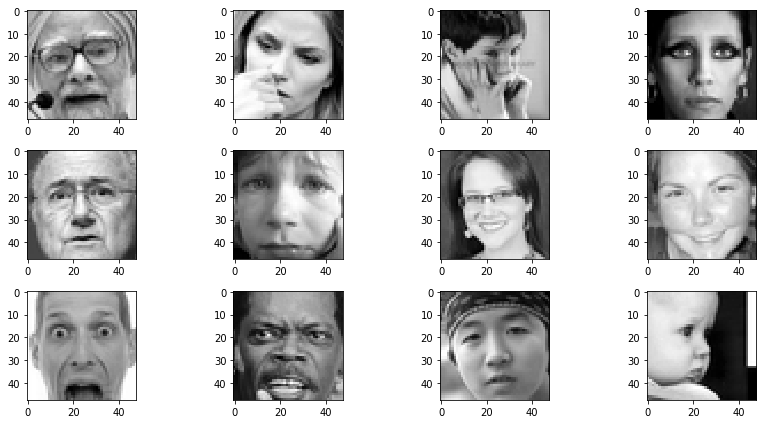

In [11]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [12]:
model = Sequential()
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))
model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)      

In [13]:
# save best weights
checkpointer = ModelCheckpoint(filepath='C:/Users/ThinkKING/Downloads/Facial-Expression-Recognition-Challenge-master/Facial-Expression-Recognition-Challenge-master/face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 10

# run model
hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)


Train on 28709 samples, validate on 3589 samples
Epoch 1/10
 - 1575s - loss: 2.0158 - accuracy: 0.2506 - val_loss: 1.6321 - val_accuracy: 0.3650

Epoch 00001: val_loss improved from inf to 1.63207, saving model to C:/Users/ThinkKING/Downloads/Facial-Expression-Recognition-Challenge-master/Facial-Expression-Recognition-Challenge-master/face_model.h5
Epoch 2/10
 - 997s - loss: 1.6560 - accuracy: 0.3509 - val_loss: 1.4922 - val_accuracy: 0.4241

Epoch 00002: val_loss improved from 1.63207 to 1.49217, saving model to C:/Users/ThinkKING/Downloads/Facial-Expression-Recognition-Challenge-master/Facial-Expression-Recognition-Challenge-master/face_model.h5
Epoch 3/10
 - 667s - loss: 1.5485 - accuracy: 0.3942 - val_loss: 1.4750 - val_accuracy: 0.4296

Epoch 00003: val_loss improved from 1.49217 to 1.47503, saving model to C:/Users/ThinkKING/Downloads/Facial-Expression-Recognition-Challenge-master/Facial-Expression-Recognition-Challenge-master/face_model.h5
Epoch 4/10
 - 715s - loss: 1.4687 - ac

In [18]:

from keras.models import model_from_json
import numpy as np

class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                     "Fear", "Happy",
                     "Sad", "Surprise",
                     "Neutral"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        print("Model loaded from disk")
        self.loaded_model.summary()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)

        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


if __name__ == '__main__':
    pass

In [ ]:
import cv2
from model import FacialExpressionModel
import numpy as np

rgb = cv2.VideoCapture(0)
facec = cv2.CascadeClassifier('C:/Users/ThinkKING/Downloads/Facial-Expression-Recognition-Challenge-master/Facial-Expression-Recognition-Challenge-master/haarcascade_frontalface_default.xml')
font = cv2.FONT_HERSHEY_SIMPLEX

def __get_data__():
    """
    __get_data__: Gets data from the VideoCapture object and classifies them
    to a face or no face. 
    
    returns: tuple (faces in image, frame read, grayscale frame)
    """
    _, fr = rgb.read()
    gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
    faces = facec.detectMultiScale(gray, 1.3, 5)
    
    return faces, fr, gray

def start_app(cnn):
    skip_frame = 10
    data = []
    flag = False
    ix = 0
    while True:
        ix += 1
        
        faces, fr, gray_fr = __get_data__()
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            
            roi = cv2.resize(fc, (48, 48))
            pred = cnn.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        if cv2.waitKey(1) == 27:
            break
        cv2.imshow('Filter', fr)
    cv2.destroyAllWindows()


if __name__ == '__main__':
    model = FacialExpressionModel("face_model.json", "face_model.h5")
    start_app(model)

Using TensorFlow backend.



Model loaded from disk
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (